# Лабораторная работа №1

Я выбрал для работы научные публикации связанные с темой **Gambling**

## Выгрузка данных

In [1]:
import requests
import xml.etree.ElementTree as ET
import json
import os
import time

API = "http://export.arxiv.org/api/query"
THEME = "gambling"
OUTPUT_FILE = "gambling_data.json"
MAX_DATA_SIZE = 500

def get_gambling_data_xml(start=0, batch_size=100):
    query = f"search_query=all:{THEME}&start={start}&max_results={batch_size}"
    url = f"{API}?{query}"

    response = requests.get(url)
    response.raise_for_status()

    root = ET.fromstring(response.content)

    return root

def read_xml(xml_root: ET.Element, output: list):
    namespace = {"atom": "http://www.w3.org/2005/Atom"}
    rows_added = 0
    for entry in xml_root.findall('atom:entry', namespace):
        authors = entry.findall('atom:author', namespace)
        row = {
            "title": entry.find('atom:title', namespace).text,
            "id": entry.find('atom:id', namespace).text,
            "published": entry.find('atom:published', namespace).text,
            "summary": entry.find('atom:summary', namespace).text,
            "authors": [author.find('atom:name', namespace).text for author in authors]
        }
        output.append(row)
        rows_added += 1
    return rows_added

def fetch_gambling_data(output_file=OUTPUT_FILE):
    batch_size = 100
    total_rows = 0
    data = []

    while total_rows < MAX_DATA_SIZE:
        print(f"Fetching data from {total_rows} to {total_rows + batch_size}")
        xml_root = get_gambling_data_xml(total_rows, batch_size)
        rows_added = read_xml(xml_root, data)
        if rows_added == 0:
            print("No more data found, exiting")
            break

        total_rows += rows_added
        print(f"Added {rows_added} rows to {output_file}, total rows: {total_rows}")
        time.sleep(1)
    
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

fetch_gambling_data()

Fetching data from 0 to 100
Added 100 rows to gambling_data.json, total rows: 100
Fetching data from 100 to 200
Added 100 rows to gambling_data.json, total rows: 200


KeyboardInterrupt: 

## Выделение ключевых слов и построение связи между ними

Объединим название и описание в один текст

In [2]:
import json

with open('gambling_data.json', 'r') as f:
    articles = json.load(f)

data = [article['title'] + ' ' + article['summary'] for article in articles]

Воспользуемся алгоритмом TF-IDF, чтобы получить топ N ключевых униграмм и биграмм для каждой статьи. 
Также воспользуемся гиперпараметрами 
- min_df: минимальное число статей в которых может встречаться слово или фраза
- max_df: ограничивает максимальное число статей в которых может встречаться слово или фраза

Также расширим список стоп-слов некоторыми словами научной тематики, для этого подсчитаем самые популярные слова

In [ ]:
from collections import Counter
import itertools

words = []
for text in data:
    words += [w.lower() for w in text.split()]

cnt = Counter(words)
custom_stop_words = set(map(lambda x: x[0], cnt.most_common(100)))
custom_stop_words


{'a',
 'all',
 'also',
 'an',
 'and',
 'approach',
 'are',
 'as',
 'at',
 'based',
 'be',
 'been',
 'between',
 'both',
 'but',
 'by',
 'can',
 'data',
 'demonstrate',
 'design',
 'detector',
 'different',
 'dune',
 'each',
 'experiment',
 'far',
 'first',
 'for',
 'from',
 'gambles',
 'gambling',
 'game',
 'has',
 'have',
 'how',
 'however,',
 'in',
 'information',
 'into',
 'is',
 'it',
 'its',
 'method',
 'model',
 'models',
 'more',
 'neutrino',
 'new',
 'not',
 'number',
 'of',
 'on',
 'one',
 'online',
 'only',
 'optimal',
 'or',
 'other',
 'our',
 'over',
 'paper',
 'physics',
 'present',
 'probability',
 'problem',
 'provide',
 'quantum',
 'random',
 'results',
 'risk',
 'set',
 'show',
 'some',
 'strategy',
 'study',
 'such',
 'than',
 'that',
 'the',
 'their',
 'theory',
 'these',
 'they',
 'this',
 'time',
 'to',
 'two',
 'under',
 'use',
 'used',
 'using',
 'was',
 'we',
 'well',
 'when',
 'where',
 'which',
 'while',
 'will',
 'with'}

Аналогично поступип с биграммами

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', min_df=5)
X = vectorizer.fit_transform(data)
bi_terms = vectorizer.get_feature_names_out()
bi_counts = X.sum(axis=0).A1
bi_top = sorted(zip(bi_terms, bi_counts), key=lambda x: x[1], reverse=True)[:50]
print(bi_top)


[('far detector', np.int64(62)), ('decision making', np.int64(55)), ('liquid argon', np.int64(44)), ('deep underground', np.int64(41)), ('neutrino experiment', np.int64(39)), ('underground neutrino', np.int64(39)), ('quantum dot', np.int64(36)), ('experiment dune', np.int64(30)), ('quantum mechanics', np.int64(30)), ('desirable gambles', np.int64(29)), ('dune far', np.int64(29)), ('protodune sp', np.int64(29)), ('dark matter', np.int64(27)), ('sets desirable', np.int64(27)), ('machine learning', np.int64(26)), ('time projection', np.int64(26)), ('online gambling', np.int64(25)), ('expected utility', np.int64(23)), ('long baseline', np.int64(23)), ('argon time', np.int64(22)), ('near detector', np.int64(22)), ('baseline neutrino', np.int64(21)), ('design report', np.int64(21)), ('large scale', np.int64(21)), ('particle physics', np.int64(21)), ('projection chamber', np.int64(21)), ('single phase', np.int64(21)), ('physics program', np.int64(20)), ('quantum dots', np.int64(20)), ('phase 

Как видим среди оставшихся биграмм (без английских стоп-слов) нет тех, которые следовало бы исключить, так как самая популярная ("far detector) встречается всего 62 раза - что почти в 7 раз меньше числа статей

In [128]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

all_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

TOP_N = 5

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words=all_stop_words,
    min_df=5, # Слова и фразы, которые встречаются хотя бы в 5 статьях
    max_df=0.7, # Слова и фразы, которые встречаются в не более чем в 70% статей
)
tfidf_matrix = vectorizer.fit_transform(data)
all_keywords = vectorizer.get_feature_names_out()

articles_keywords = []
for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(i)
    indices = np.argsort(row.toarray()[0])[-TOP_N:][::-1]
    keywords = [all_keywords[idx] for idx in indices]
    articles_keywords.append(keywords)


Построим граф связей между ключевыми статьями с помощью networkx

In [139]:
import networkx as nx
from itertools import combinations

G = nx.Graph()

for keywords in articles_keywords:
    for u, v in combinations(keywords, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

In [134]:
print(f'Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}')

Number of nodes: 460, Number of edges: 17095


Визуализируем полученный граф

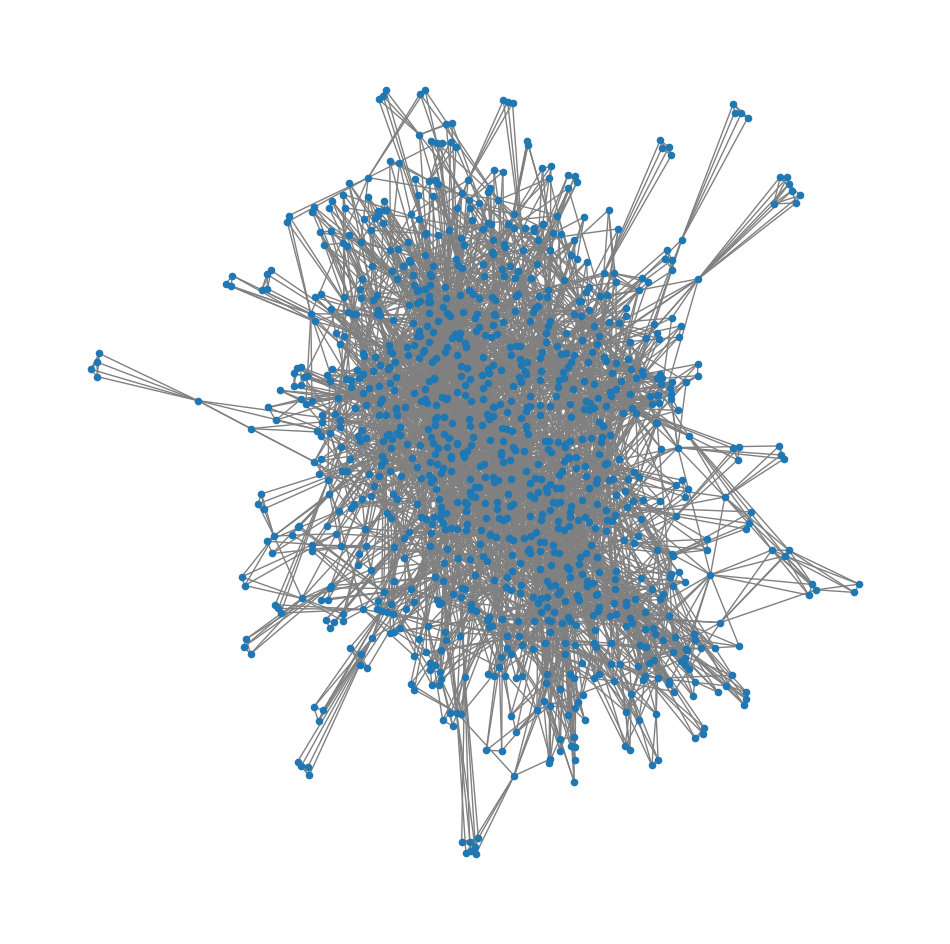

In [140]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx(G, pos, with_labels=False, node_size=20, edge_color='gray')
plt.axis('off')
plt.show()

Можно отфильтровать вершины графа, оставив только те, у кого, больше связей, чтобы взглянуть на самые популярные слова

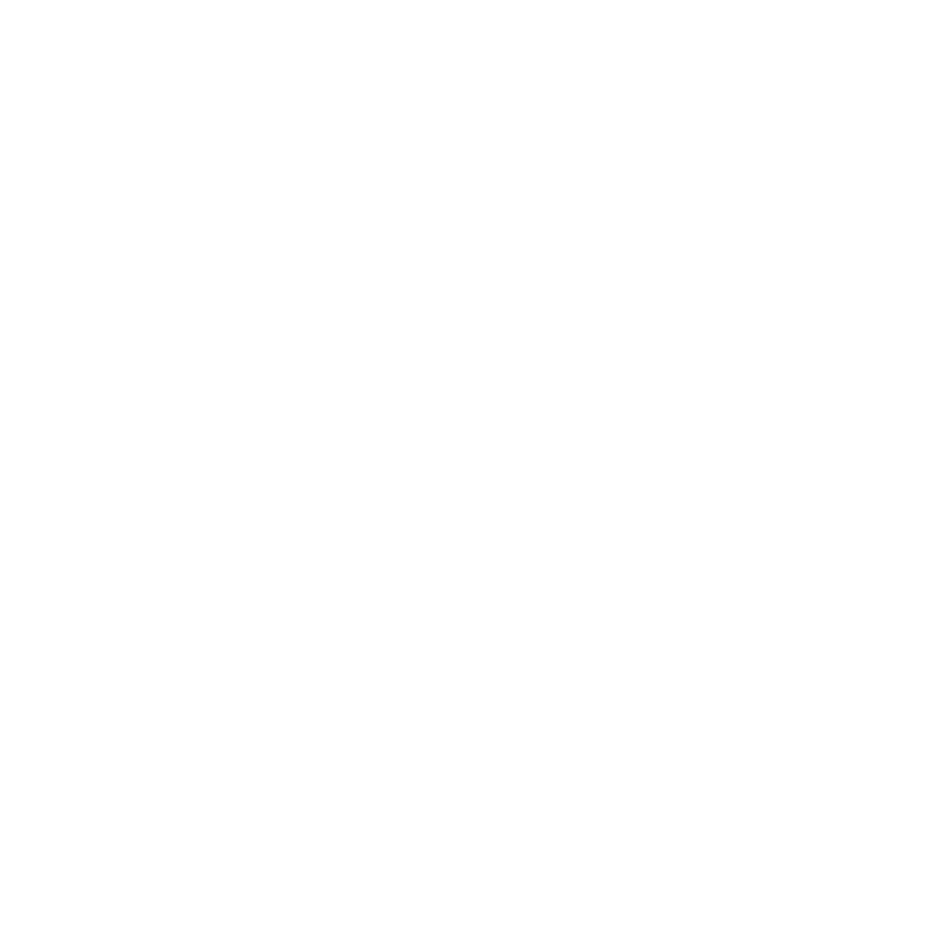

In [141]:
MIN_DEGREE = 80

nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree > MIN_DEGREE]
subG = G.subgraph(nodes_to_keep).copy()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx(subG, pos, with_labels=True, font_size=16, node_size=50, edge_color='gray')
plt.axis('off')
plt.show()

## Оценка качества кластеризации

Используем алгоритм Louvain для выделения кластеров и анализа модулярности

In [147]:
clusters = nx.community.louvain_communities(G)
modularity = nx.community.modularity(G, clusters)
print(f'Number of clusters: {len(clusters)}, Modularity: {modularity}')

Number of clusters: 18, Modularity: 0.6292216769166341


Получилась средняя связность, и небольшое число кластеров - тематики сильно связаны между собой и часто перекликаются

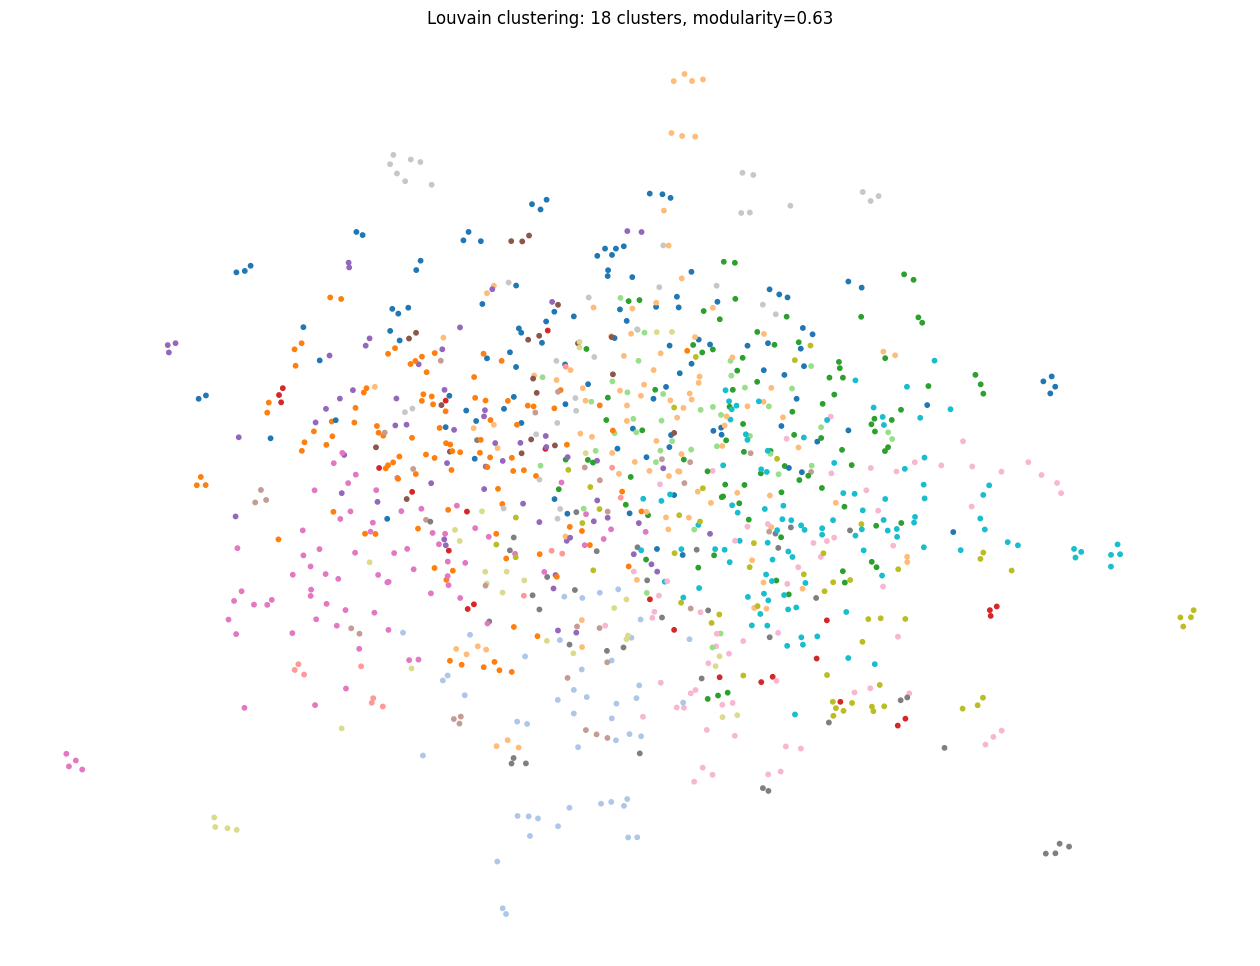

In [149]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


import matplotlib.colors as mcolors

def get_color_map(n):
    # Преимущественно дискретные палитры
    if n <= 10:
        cmap = plt.get_cmap('tab10')
    elif n <= 20:
        cmap = plt.get_cmap('tab20')
    else:
        cmap = plt.get_cmap('hsv')
    return [cmap(i / n) for i in range(n)]

def colorize():
    node2cluster = {}
    for cluster_id, nodes in enumerate(clusters):
        for node in nodes:
            node2cluster[node] = cluster_id
    n_clusters = len(clusters)

    palette = get_color_map(n_clusters)

    colors = [palette[node2cluster[node]] for node in G.nodes()]

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=10, alpha=1)

    plt.axis('off')
    plt.title(f'Louvain clustering: {n_clusters} clusters, modularity={modularity:.2f}')
    plt.show()

colorize()

## Поиск ключевых слов

Найдем топ N ключевых слов по каждой мере:
- degree centrality - популярность узла, (его степень)
- betweenness centrality - узлы, которые связывают между собой кластера
- eigenvector centrality - ключевые узлы для тематики, т.е. узлы у которых много связей с другими важными узлами
- closeness centrality - насколько близко узел ко всем остальным, то есть универсальность

In [85]:
import pandas as pd

CENTRALITY_N = 5

def eval_centrality(graph, func, name, n=CENTRALITY_N):
    centrality = func(graph)
    top = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:n]
    df = pd.DataFrame(top, columns=['feature', name])
    print(df.to_string(index=False))
    print()
    return top

In [86]:
degree_top = eval_centrality(G, nx.degree_centrality, 'degree_centrality')
betweenness_top = eval_centrality(G, nx.betweenness_centrality, 'betweenness_centrality')
eigenvector_top = eval_centrality(G, nx.eigenvector_centrality, 'eigenvector_centrality')
closeness_top = eval_centrality(G, nx.closeness_centrality, 'closeness_centrality')

   feature  degree_centrality
     games           0.081395
   betting           0.075581
strategies           0.069767
   utility           0.068314
 algorithm           0.063953

   feature  betweenness_centrality
     games                0.046383
   betting                0.033544
strategies                0.031444
 algorithm                0.027946
   utility                0.027080

    feature  eigenvector_centrality
    betting                0.162932
 strategies                0.155349
    utility                0.152201
      games                0.142188
uncertainty                0.119005

   feature  closeness_centrality
   betting              0.419001
     games              0.417729
     agent              0.410992
strategies              0.410012
   utility              0.408066



По результатам видно, что есть явная смесь двух тем - квантовая физика и теория вероятности,

## Построение графа публикаций

Будем ориентироваться на найденные в начале ключевые слова для каждой статьи

In [164]:
from itertools import combinations
import networkx as nx

A = nx.Graph()

for i, j in combinations(range(len(articles_keywords)), 2):
    intersect = set(articles_keywords[i]).intersection(set(articles_keywords[j]))
    if (len(intersect) > 0):
        A.add_edge(i, j, weight=len(intersect))

In [165]:
print(f'Number of nodes: {A.number_of_nodes()}, Number of edges: {A.number_of_edges()}')

Number of nodes: 461, Number of edges: 2490


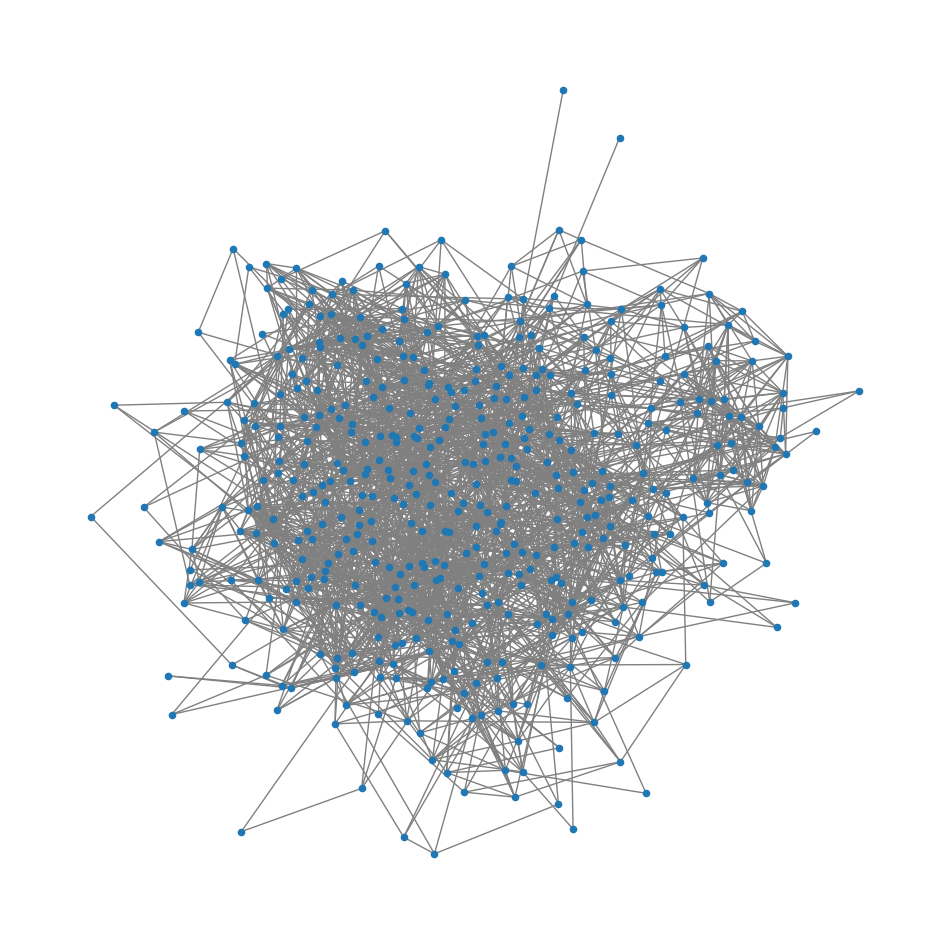

In [166]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(A, k=0.3)
nx.draw_networkx(A, pos, with_labels=False, node_size=20, edge_color='gray')
plt.axis('off')
plt.show()

Теперь напишем функцию для поиска ближайших соседей. Искать будет по принципу кратчайшего пути - то есть ближайшие статьи это те, до кототорых путь короче.

Чтобы учесть веса связей, будем искать кратчайшие пути по обратному весу, то есть чем больше вес -> тем меньше обратная величина -> тем ближе узел

In [172]:
for u, v, d in A.edges(data=True):
    if d["weight"] == 0:
        d["inv_weight"] = 100000
    else:
        d["inv_weight"] = 1. / d["weight"]

def find_closest_articles(target_index, top_n=10):
    lengths = nx.single_source_dijkstra_path_length(A, target_index, weight='inv_weight')
    closest = [(idx, dist) for idx, dist in lengths.items() if idx != target_index]
    closest.sort(key=lambda x: x[1])
    return closest[:top_n]

def print_closest(closest):
    print("Ближайшие статьи:")
    for i, (idx, dist) in enumerate(closest):
        print(f'{i + 1}. {articles[idx]["title"]} (dist={dist:.2f})')

In [173]:
TARGET_ARTICLE = 0

print(f'Целевая статья: {articles[TARGET_ARTICLE]["title"]}')

closest = find_closest_articles(TARGET_ARTICLE)
print_closest(closest)

Целевая статья: Automatic detection of problem-gambling signs from online texts using
  large language models
Ближайшие статьи:
1. Delving into Youth Perspectives on In-game Gambling-like Elements: A
  Proof-of-Concept Study Utilising Large Language Models for Analysing
  User-Generated Text Data (dist=1.00)
2. Improving and benchmarking of algorithms for $Γ$-maximin,
  $Γ$-maximax and interval dominance (dist=1.00)
3. CONFLARE: CONFormal LArge language model REtrieval (dist=1.00)
4. Improving and benchmarking of algorithms for decision making with lower
  previsions (dist=1.50)
5. An End-to-End Set Transformer for User-Level Classification of
  Depression and Gambling Disorder (dist=2.00)
6. Malicious User Experience Design Research for Cybersecurity (dist=2.00)
7. Dressed to Gamble: How Poker Drives the Dynamics of Wearables and Visits
  on Decentraland's Social Virtual World (dist=2.00)
8. Speculating LLMs' Chinese Training Data Pollution from Their Tokens (dist=2.00)
9. Beyond App 